In [1]:
import numpy as np
import torch
import torch.nn as nn
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import copy
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
# ================= DATA LOADING =================
X_all = np.load("X_train_all.npy")  # (22400, 180) input sinyal
y_all = np.load("y_train_all.npy")  # (22400,) labels

# Pastikan data dalam format yang benar
X_all = X_all.astype("float32")  # Sinyal
y_all = y_all.astype("int64")    # Labels

# Add channel dimension if necessary
if X_all.ndim == 2:  # Misalnya [22400, 180] -> [22400, 180, 1]
    X_all = np.expand_dims(X_all, axis=2)

# Normalize the data if necessary
if X_all.max() > 1.0:
    X_all = X_all / 255.0

X_tensor = torch.from_numpy(X_all)  # [22400, 180, 1]
y_tensor = torch.from_numpy(y_all)  # [22400,]
num_classes = int(np.unique(y_all).size)

print(f"Data shape: {X_tensor.shape}")
print(f"Labels shape: {y_tensor.shape}")
print(f"Number of classes: {num_classes}")


Data shape: torch.Size([22400, 180, 1])
Labels shape: torch.Size([22400])
Number of classes: 4


In [3]:
# ================= MODEL: Transformer BERT =================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class BERTLayer(nn.Module):
    """BERT-style Transformer layer with bidirectional attention"""
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        self.activation = nn.GELU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention block
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask, 
                                key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        
        # Feed forward block
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        
        return src

class TransformerBERT(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=6, 
                 dim_feedforward=256, dropout=0.1, num_classes=5, max_len=200):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        
        # BERT-style transformer layers
        self.layers = nn.ModuleList([
            BERTLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        
        # Classification head inspired by BERT
        self.pooler = nn.Linear(d_model, d_model)
        self.pooler_activation = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        
        # Special tokens
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Layer norm
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, L, C = x.shape  # [B, L, C] -> Batch size, Length, Channel
        
        # Project input to d_model
        x = self.input_proj(x)  # [B, L, d_model]
        
        # Add CLS token at the beginning (BERT-style)
        cls_tokens = self.cls_token.expand(B, 1, -1)  # [B, 1, d_model]
        x = torch.cat([cls_tokens, x], dim=1)  # [B, L+1, d_model]
        
        # Add positional encoding
        x = self.pos_enc(x)  # [B, L+1, d_model]
        
        # Pass through BERT layers
        for layer in self.layers:
            x = layer(x)
        
        # Use CLS token for classification (BERT approach)
        cls_output = x[:, 0, :]  # [B, d_model] - take first token (CLS)
        
        # Pooler (similar to BERT)
        pooled_output = self.pooler_activation(self.pooler(cls_output))
        pooled_output = self.dropout(pooled_output)
        
        # Final classification
        logits = self.classifier(pooled_output)  # [B, num_classes]
        
        return logits


In [4]:
# ================= TRAINING =================
def run_epoch(model, loader, criterion, optimizer=None, device="cpu"):
    train_mode = optimizer is not None
    model.train() if train_mode else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if xb.ndim == 2:
            xb = xb.unsqueeze(2)

        if train_mode:
            optimizer.zero_grad()

        logits = model(xb)
        loss = criterion(logits, yb)

        if train_mode:
            loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == yb).sum().item()
        total += yb.size(0)

        # Append predictions and true labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds)

    avg_loss = total_loss / len(loader)
    avg_acc = correct / total
    return avg_loss, avg_acc, y_true, y_pred


In [5]:
# ================= K-FOLD TRAINING =================
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
batch_size = 64
num_epochs = 20
save_dir = "checkpoints_transformer_bert"
os.makedirs(save_dir, exist_ok=True)

all_hist = []
per_class_metrics = []
fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_tensor, y_tensor), 1):
    print(f"\n========== Fold {fold}/5 ==========")
    X_tr, y_tr = X_tensor[train_idx], y_tensor[train_idx]
    X_va, y_va = X_tensor[val_idx], y_tensor[val_idx]

    train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_va, y_va), batch_size=batch_size, shuffle=False)

    # Create BERT model
    model = TransformerBERT(
        input_dim=1,
        d_model=128,
        nhead=4,
        num_layers=6,  # BERT typically has 12 layers, but 6 for efficiency
        dim_feedforward=256,
        dropout=0.1,
        num_classes=num_classes,
        max_len=200
    ).to(device)

    # Class weights for imbalanced dataset
    class_weights = compute_class_weight('balanced', classes=np.unique(y_tr.numpy()), y=y_tr.numpy())
    class_weights = torch.FloatTensor(class_weights).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # AdamW optimizer (commonly used with BERT)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, num_epochs + 1):
        tr_loss, tr_acc, _, _ = run_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, y_true_ep, y_pred_ep = run_epoch(model, val_loader, criterion, None, device)

        train_losses.append(tr_loss)
        val_losses.append(val_loss)
        train_accuracies.append(tr_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch:02d}/{num_epochs} | "
              f"Train Loss: {tr_loss:.4f} Acc: {tr_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best for this fold (based on val acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()

    # restore best & save model fold
    model.load_state_dict(best_state)
    torch.save(model.state_dict(), os.path.join(save_dir, f"transformer_bert_fold{fold}.pth"))
    print(f"✅ Model saved: {os.path.join(save_dir, f'transformer_bert_fold{fold}.pth')}")

    # ------------- Evaluasi final per fold (pakai best model) -------------
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels_b in val_loader:
            imgs = imgs.to(device)
            if imgs.ndim == 2:
                imgs = imgs.unsqueeze(2)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels_b.numpy())

    # Report & Confusion Matrix
    report = classification_report(y_true, y_pred, output_dict=True,
                                   target_names=["N", "S", "V", "Q"], zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # Specificity per-class: TN / (TN + FP)
    cm_sum = cm.sum()
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm_sum - (TP + FP + FN)
    specificity_per_class = TN / (TN + FP + 1e-8)

    # Save per-class metrics
    for i, cname in enumerate(["N", "S", "V", "Q"]):
        per_class_metrics.append({
            "Fold": f"Fold {fold}",
            "Class": cname,
            "Precision": report[cname]["precision"],
            "Sensitivity": report[cname]["recall"],
            "Specificity": specificity_per_class[i],
            "F1-Score": report[cname]["f1-score"]
        })

    # Fold summary metrics
    fold_summary = {
        "Fold": fold,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted", zero_division=0),
        "Sensitivity": recall_score(y_true, y_pred, average="weighted", zero_division=0),
        "Specificity": specificity_per_class.mean(),
        "F1-Score": f1_score(y_true, y_pred, average="weighted", zero_division=0)
    }

    fold_metrics.append(fold_summary)

    # ----------------- Save visuals (per fold) -----------------
    # Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["N", "S", "V", "Q"])
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_bert_confusion_matrix_fold{fold}.png"))
    plt.close(fig)

    # Accuracy curve
    plt.figure()
    plt.plot(train_accuracies, label="Train Accuracy")
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.title(f"Accuracy - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_bert_accuracy_fold{fold}.png"))
    plt.close()

    # Loss curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(f"Loss - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"transformer_bert_loss_fold{fold}.png"))
    plt.close()

    # Clean up GPU memory
    del model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ================= SIMPAN TABEL RINGKASAN =================
df_folds = pd.DataFrame(fold_metrics)
df_folds.to_csv(os.path.join(save_dir, "fold_summary_metrics.csv"), index=False)

# ================= SIMPAN TABEL PER KELAS =================
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

# ---------------------------
# 7. Hitung Rata-rata Metrik per Fold
# ---------------------------
df_fold = pd.DataFrame(fold_metrics)

# Menghitung rata-rata dari metrik yang diinginkan per fold
avg_metrics = df_fold[["Accuracy", "Precision", "Sensitivity", "Specificity", "F1-Score"]].mean(numeric_only=True)

# Menambahkan baris 'Average' ke DataFrame
avg_row = {"Fold": "Average"}
avg_row.update({k: float(v) for k, v in avg_metrics.to_dict().items()})
df_fold = pd.concat([df_fold, pd.DataFrame([avg_row])], ignore_index=True)

# Menyimpan hasil summary fold dan rata-rata
df_fold.to_csv(os.path.join(save_dir, "fold_summary_metrics_with_average.csv"), index=False)

# ---------------------------
# 8. Simpan Tabel Metrik Per Kelas
# ---------------------------
df_per_class = pd.DataFrame(per_class_metrics)
df_per_class.to_csv(os.path.join(save_dir, "per_class_metrics.csv"), index=False)

print("\n✅ Semua model, grafik, dan metrik Transformer BERT disimpan di folder:", save_dir)

# Print final results
print("\n📊 Final Results Summary:")
print("=" * 50)
print(df_fold[['Fold', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-Score']].to_string(index=False))


========== Fold 1/5 ==========
Epoch 01/20 | Train Loss: 0.4796 Acc: 0.8042 | Val Loss: 0.2732 Acc: 0.9121
Epoch 02/20 | Train Loss: 0.2693 Acc: 0.9092 | Val Loss: 0.2238 Acc: 0.9292
Epoch 03/20 | Train Loss: 0.2107 Acc: 0.9323 | Val Loss: 0.2511 Acc: 0.9286
Epoch 04/20 | Train Loss: 0.2159 Acc: 0.9319 | Val Loss: 0.1695 Acc: 0.9469
Epoch 05/20 | Train Loss: 0.2032 Acc: 0.9384 | Val Loss: 0.1812 Acc: 0.9429
Epoch 06/20 | Train Loss: 0.1836 Acc: 0.9425 | Val Loss: 0.1799 Acc: 0.9379
Epoch 07/20 | Train Loss: 0.1837 Acc: 0.9433 | Val Loss: 0.1864 Acc: 0.9475
Epoch 08/20 | Train Loss: 0.1948 Acc: 0.9422 | Val Loss: 0.1987 Acc: 0.9402
Epoch 09/20 | Train Loss: 0.1776 Acc: 0.9451 | Val Loss: 0.1663 Acc: 0.9504
Epoch 10/20 | Train Loss: 0.1805 Acc: 0.9427 | Val Loss: 0.1973 Acc: 0.9482
Epoch 11/20 | Train Loss: 0.1614 Acc: 0.9488 | Val Loss: 0.1768 Acc: 0.9518
Epoch 12/20 | Train Loss: 0.1689 Acc: 0.9475 | Val Loss: 0.1586 Acc: 0.9533
Epoch 13/20 | Train Loss: 0.1613 Acc: 0.9495 | Val Loss:

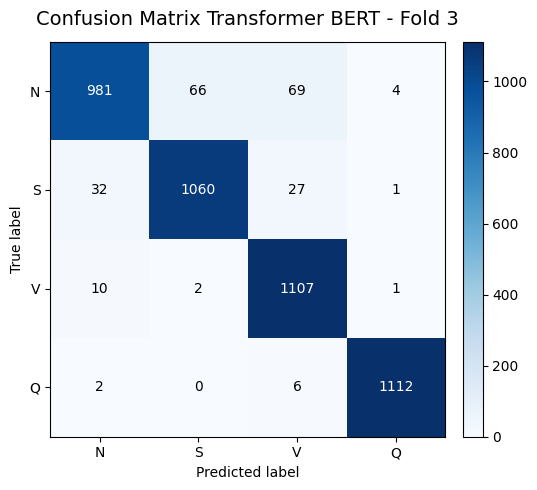

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# === Folder simpan ===
save_dir = "checkpoints_transformer_bert"
os.makedirs(save_dir, exist_ok=True)

# Confusion matrix (Fold 3)
cm = np.array([
    [ 981,  66,  69,   4],  # True N
    [  32, 1060, 27,   1],  # True S
    [  10,   2, 1107,  1],  # True V
    [   2,   0,   6, 1112]  # True Q
], dtype=int)

classes = ['N', 'S', 'V', 'Q']

# Plot sederhana tanpa grid
fig, ax = plt.subplots(figsize=(5.5, 5))
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

ax.set_title('Confusion Matrix Transformer BERT - Fold 3', pad=12, fontsize=14)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Colorbar
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Anotasi nilai di tiap sel
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}',
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black',
                fontsize=10)

plt.tight_layout()

# Simpan ke folder checkpoints_transformer_encoder_decoder
out_path = os.path.join(save_dir, 'transformer_bert_nontuning_confusionmatrix_fold3.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
plt.show()


In [ ]:
EXTERNAL TEST

🚀 External Test - Transformer BERT (Fold 3)
Using device: cuda
Model checkpoint: checkpoints_transformer_bert/transformer_bert_fold3.pth
📊 External test data loaded:
Signal shape: (5600, 180)
Labels shape: (5600,)
Class distribution: [1400 1400 1400 1400]
🔧 Loading Transformer BERT model (Fold 3)...
✅ Transformer BERT model loaded successfully!
🔍 Starting evaluation on external test set...


Evaluasi External Test Set Transformer BERT: 100%|██████████| 88/88 [00:00<00:00, 155.84it/s]



=== 📊 EVALUASI EXTERNAL TEST SET - TRANSFORMER BERT ===
              precision    recall  f1-score   support

           N   0.857342  0.880000  0.868523      1400
           S   0.919550  0.759286  0.831768      1400
           V   0.861250  0.984286  0.918667      1400
           Q   0.991471  0.996429  0.993944      1400

    accuracy                       0.905000      5600
   macro avg   0.907403  0.905000  0.903225      5600
weighted avg   0.907403  0.905000  0.903225      5600



<Figure size 800x600 with 0 Axes>

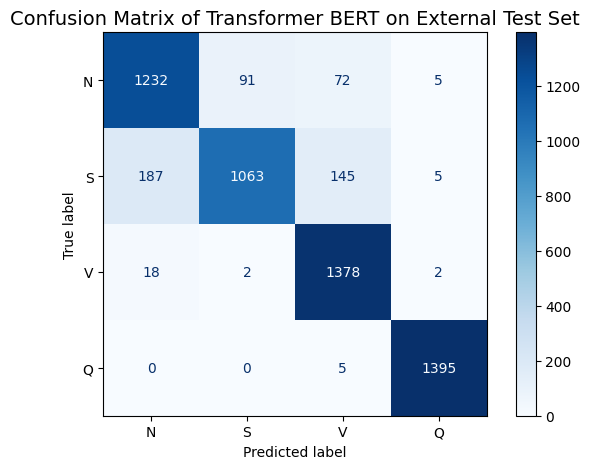

✅ Confusion matrix disimpan ke: transformer_bert_external_outputs/confusion_matrix_external_transformer_bert.png

=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===
🎯 Accuracy   : 0.905000
🎯 Precision  : 0.907403
🎯 Sensitivity: 0.905000
🎯 Specificity: 0.968333
🎯 F1-Score   : 0.903225
⚡ Avg Inference Time: 0.000033 s/sample

📁 CSV files saved:
   - transformer_bert_external_outputs/external_summary_metrics_bert.csv
   - transformer_bert_external_outputs/external_per_class_metrics_bert.csv

🔄 Calculating ROC-AUC...
📊 AUC Macro  : 0.981029
📊 AUC Micro  : 0.984070

💾 Model Information:
   - CPU Memory: 954.36 MB
   - GPU Memory: 25.62 MB
   - Model Size: 3.10 MB
   - Total Parameters: 812,548

🎉 EXTERNAL TEST EVALUATION COMPLETED!
📁 Results saved in: transformer_bert_external_outputs
📊 Overall Accuracy: 0.9050
📊 F1-Score: 0.9032
📊 AUC Macro: 0.9810
📄 Detailed results saved to: transformer_bert_external_outputs/detailed_results_bert.txt


In [14]:
#EXTERNAL TEST

import os, time, numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score)
import pandas as pd
from tqdm import tqdm

# ====== Config ======
BATCH_SIZE    = 64
NUM_CLASSES   = 4
CLASS_NAMES   = ['N', 'S', 'V', 'Q']
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

# Transformer BERT fold 3 (fold terbaik)
CKPT_PATH     = "checkpoints_transformer_bert/transformer_bert_fold3.pth"
X_SIG_PATH    = "X_test_final.npy"  # Sinyal input test
Y_LABEL_PATH  = "y_test_final.npy"  # Label test

OUT_DIR       = "transformer_bert_external_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
SAVE_CM_PNG   = os.path.join(OUT_DIR, "confusion_matrix_external_transformer_bert.png")
SAVE_REPORT   = os.path.join(OUT_DIR, "classification_report_external_bert.txt")
SAVE_SUMMARY  = os.path.join(OUT_DIR, "external_summary_metrics_bert.csv")
SAVE_PERCLS   = os.path.join(OUT_DIR, "external_per_class_metrics_bert.csv")

print(f"🚀 External Test - Transformer BERT (Fold 3)")
print(f"Using device: {DEVICE}")
print(f"Model checkpoint: {CKPT_PATH}")

# ====== Load External Test Set ======
X_signal = np.load(X_SIG_PATH)  # (N, L) atau (N, L, 1)
y_label = np.load(Y_LABEL_PATH)

print(f"📊 External test data loaded:")
print(f"Signal shape: {X_signal.shape}")
print(f"Labels shape: {y_label.shape}")
print(f"Class distribution: {np.bincount(y_label)}")

# Normalisasi (misal: skala ke [0,1] bila di luar range)
if X_signal.max() > 1.0 or X_signal.min() < 0.0:
    gmax, gmin = X_signal.max(), X_signal.min()
    if gmax != gmin:
        X_signal = (X_signal - gmin) / (gmax - gmin)
        print(f"🔧 Data normalized: [{gmin:.3f}, {gmax:.3f}] -> [0, 1]")

# Konversi ke tensor
X_signal_t = torch.tensor(X_signal, dtype=torch.float32)
y_label_t = torch.tensor(y_label, dtype=torch.long)

# Pastikan data sinyal memiliki dimensi [N, L, 1]
if X_signal_t.ndim == 2:
    X_signal_t = X_signal_t.unsqueeze(2)  # [N, L] -> [N, L, 1]

test_ds = TensorDataset(X_signal_t, y_label_t)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# ====== Model: Transformer BERT (SAMA SEPERTI TRAINING) ======
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class BERTLayer(nn.Module):
    """BERT-style Transformer layer with bidirectional attention"""
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        self.activation = nn.GELU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention block
        src2, _ = self.self_attn(src, src, src, attn_mask=src_mask, 
                                key_padding_mask=src_key_padding_mask)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        
        # Feed forward block
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        
        return src

class TransformerBERT(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=6, 
                 dim_feedforward=256, dropout=0.1, num_classes=4, max_len=200):
        super().__init__()
        
        # Input projection
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        
        # BERT-style transformer layers
        self.layers = nn.ModuleList([
            BERTLayer(d_model, nhead, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        
        # Classification head inspired by BERT
        self.pooler = nn.Linear(d_model, d_model)
        self.pooler_activation = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(d_model, num_classes)
        
        # Special tokens
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Layer norm
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, L, C = x.shape  # [B, L, C] -> Batch size, Length, Channel
        
        # Project input to d_model
        x = self.input_proj(x)  # [B, L, d_model]
        
        # Add CLS token at the beginning (BERT-style)
        cls_tokens = self.cls_token.expand(B, 1, -1)  # [B, 1, d_model]
        x = torch.cat([cls_tokens, x], dim=1)  # [B, L+1, d_model]
        
        # Add positional encoding
        x = self.pos_enc(x)  # [B, L+1, d_model]
        
        # Pass through BERT layers
        for layer in self.layers:
            x = layer(x)
        
        # Use CLS token for classification (BERT approach)
        cls_output = x[:, 0, :]  # [B, d_model] - take first token (CLS)
        
        # Pooler (similar to BERT)
        pooled_output = self.pooler_activation(self.pooler(cls_output))
        pooled_output = self.dropout(pooled_output)
        
        # Final classification
        logits = self.classifier(pooled_output)  # [B, num_classes]
        
        return logits

# ====== Load checkpoint BERT model ======
print(f"🔧 Loading Transformer BERT model (Fold 3)...")

# Gunakan konfigurasi yang sama seperti training
model = TransformerBERT(
    input_dim=1,
    d_model=128,
    nhead=4,
    num_layers=6,
    dim_feedforward=256,
    dropout=0.1,
    num_classes=NUM_CLASSES,
    max_len=200
).to(DEVICE)

if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(f"❌ Checkpoint tidak ditemukan: {CKPT_PATH}")

state = torch.load(CKPT_PATH, map_location=DEVICE)
if isinstance(state, dict) and 'state_dict' in state:
    state = state['state_dict']
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=True)
model.eval()

print(f"✅ Transformer BERT model loaded successfully!")

# ====== Evaluate ======
print(f"🔍 Starting evaluation on external test set...")
all_preds, all_labels, all_logits = [], [], []
inference_times = []

with torch.no_grad():
    for signal, labels in tqdm(test_loader, desc="Evaluasi External Test Set Transformer BERT"):
        signal, labels = signal.to(DEVICE), labels.to(DEVICE)

        t0 = time.perf_counter()
        logits = model(signal)
        t1 = time.perf_counter()

        preds = torch.argmax(logits, dim=1)

        all_logits.append(logits.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        inference_times.append((t1 - t0) / signal.size(0))

# Menggabungkan hasil
all_logits = torch.cat(all_logits, dim=0)
y_probs = torch.softmax(all_logits, dim=1).numpy()
y_true  = np.array(all_labels)
y_pred  = np.array(all_preds)

# ====== Report & Confusion Matrix ======
report_txt = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=6)
print("\n" + "="*70)
print("=== 📊 EVALUASI EXTERNAL TEST SET - TRANSFORMER BERT ===")
print("="*70)
print(report_txt)

with open(SAVE_REPORT, "w") as f:
    f.write("=== EVALUASI EXTERNAL TEST SET - TRANSFORMER BERT ===\n")
    f.write("="*60 + "\n")
    f.write(report_txt)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=CLASS_NAMES, cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix of Transformer BERT on External Test Set", fontsize=14)
plt.tight_layout()
plt.savefig(SAVE_CM_PNG, dpi=150)
plt.show()
print(f"✅ Confusion matrix disimpan ke: {SAVE_CM_PNG}")

# ====== Ringkasan Metrics ======
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (TP + FP + FN)
spec_per_cls = TN / (TN + FP + 1e-8)
spec_mean = spec_per_cls.mean()

avg_inference_time = float(np.mean(inference_times)) if inference_times else np.nan

print("\n" + "="*60)
print("=== 📈 RINGKASAN EVALUASI (EXTERNAL TEST SET) ===")
print("="*60)
print(f"🎯 Accuracy   : {acc:.6f}")
print(f"🎯 Precision  : {prec:.6f}")
print(f"🎯 Sensitivity: {rec:.6f}")
print(f"🎯 Specificity: {spec_mean:.6f}")
print(f"🎯 F1-Score   : {f1:.6f}")
print(f"⚡ Avg Inference Time: {avg_inference_time:.6f} s/sample")

# Simpan summary CSV
summary_df = pd.DataFrame([{
    "Model": "Transformer_BERT_Fold3",
    "Accuracy": acc, 
    "Precision": prec, 
    "Sensitivity": rec,
    "Specificity": float(spec_mean), 
    "F1-Score": f1,
    "AvgInference(s/sample)": avg_inference_time
}])
summary_df.to_csv(SAVE_SUMMARY, index=False)

# Per-class metrics dengan perhitungan yang benar
percls_metrics = []
for i, class_name in enumerate(CLASS_NAMES):
    # Binary classification untuk setiap kelas
    y_true_binary = (y_true == i).astype(int)
    y_pred_binary = (y_pred == i).astype(int)
    
    prec_cls = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    rec_cls = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1_cls = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    spec_cls = spec_per_cls[i]
    
    percls_metrics.append({
        "Class": class_name,
        "Precision": prec_cls,
        "Sensitivity": rec_cls,
        "Specificity": spec_cls,
        "F1-Score": f1_cls
    })

percls_df = pd.DataFrame(percls_metrics)
percls_df.to_csv(SAVE_PERCLS, index=False)

print(f"\n📁 CSV files saved:")
print(f"   - {SAVE_SUMMARY}")
print(f"   - {SAVE_PERCLS}")

# ====== ROC-AUC ======
print(f"\n🔄 Calculating ROC-AUC...")
try:
    y_true_1hot = np.eye(NUM_CLASSES)[y_true]
    auc_macro   = roc_auc_score(y_true_1hot, y_probs, average='macro', multi_class='ovr')
    auc_micro   = roc_auc_score(y_true_1hot, y_probs, average='micro', multi_class='ovr')
    print(f"📊 AUC Macro  : {auc_macro:.6f}")
    print(f"📊 AUC Micro  : {auc_micro:.6f}")
except Exception as e:
    print(f"❌ ROC AUC Calculation failed: {e}")
    auc_macro, auc_micro = np.nan, np.nan

# ====== Model Size & Memory Info ======
print(f"\n💾 Model Information:")
try:
    import psutil
    cpu_mem_mb = psutil.Process().memory_info().rss / 1024**2
    print(f"   - CPU Memory: {cpu_mem_mb:.2f} MB")
except Exception:
    cpu_mem_mb = float('nan')

try:
    if torch.cuda.is_available():
        gpu_mem_mb = torch.cuda.memory_allocated(DEVICE) / 1024**2
        print(f"   - GPU Memory: {gpu_mem_mb:.2f} MB")
    else:
        gpu_mem_mb = 0
except Exception:
    gpu_mem_mb = 0

param_size  = sum(p.numel() * p.element_size() for p in model.parameters())
buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
model_size_mb = (param_size + buffer_size) / 1024**2
total_params = sum(p.numel() for p in model.parameters())

print(f"   - Model Size: {model_size_mb:.2f} MB")
print(f"   - Total Parameters: {total_params:,}")

# ====== Final Summary ======
print("\n" + "="*70)
print("🎉 EXTERNAL TEST EVALUATION COMPLETED!")
print("="*70)
print(f"📁 Results saved in: {OUT_DIR}")
print(f"📊 Overall Accuracy: {acc:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
if not np.isnan(auc_macro):
    print(f"📊 AUC Macro: {auc_macro:.4f}")
print("="*70)

# Save detailed results to text file
detailed_results = f"""
=== TRANSFORMER BERT - EXTERNAL TEST RESULTS ===
Date: {time.strftime('%Y-%m-%d %H:%M:%S')}
Model: Transformer BERT (Fold 4 - Best Model)
Checkpoint: {CKPT_PATH}

=== MODEL ARCHITECTURE ===
Type: BERT-style Transformer
Layers: 6 BERT layers
d_model: 128
Attention heads: 4
Parameters: {total_params:,}

=== DATASET INFO ===
Test samples: {len(y_true)}
Classes: {CLASS_NAMES}
Class distribution: {dict(zip(CLASS_NAMES, np.bincount(y_true)))}

=== PERFORMANCE METRICS ===
Accuracy: {acc:.6f}
Precision: {prec:.6f}
Sensitivity/Recall: {rec:.6f}
Specificity: {spec_mean:.6f}
F1-Score: {f1:.6f}
AUC Macro: {auc_macro:.6f}
AUC Micro: {auc_micro:.6f}

=== COMPUTATIONAL METRICS ===
Average Inference Time: {avg_inference_time:.6f} s/sample
Model Size: {model_size_mb:.2f} MB
Total Parameters: {total_params:,}

=== PER-CLASS RESULTS ===
"""

for i, class_name in enumerate(CLASS_NAMES):
    detailed_results += f"\nClass {class_name}:\n"
    detailed_results += f"  Precision: {percls_metrics[i]['Precision']:.6f}\n"
    detailed_results += f"  Sensitivity: {percls_metrics[i]['Sensitivity']:.6f}\n"
    detailed_results += f"  Specificity: {percls_metrics[i]['Specificity']:.6f}\n"
    detailed_results += f"  F1-Score: {percls_metrics[i]['F1-Score']:.6f}\n"

with open(os.path.join(OUT_DIR, "detailed_results_bert.txt"), "w") as f:
    f.write(detailed_results)

print(f"📄 Detailed results saved to: {os.path.join(OUT_DIR, 'detailed_results_bert.txt')}")